In [682]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [683]:
#set display option for rows & columns

pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [684]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('data/train_afterFE.csv')
print(train_df.shape)

test_df = pd.read_csv('data/test_afterFE.csv')
print(test_df.shape)

(590494, 122)
(506691, 136)


# Removing highly co-related D and C features

D features

In [685]:
D_columns = [f'D{i}' for i in range(1, 15) if f'D{i}' in train_df.columns]
D_features_train_df = train_df[D_columns]


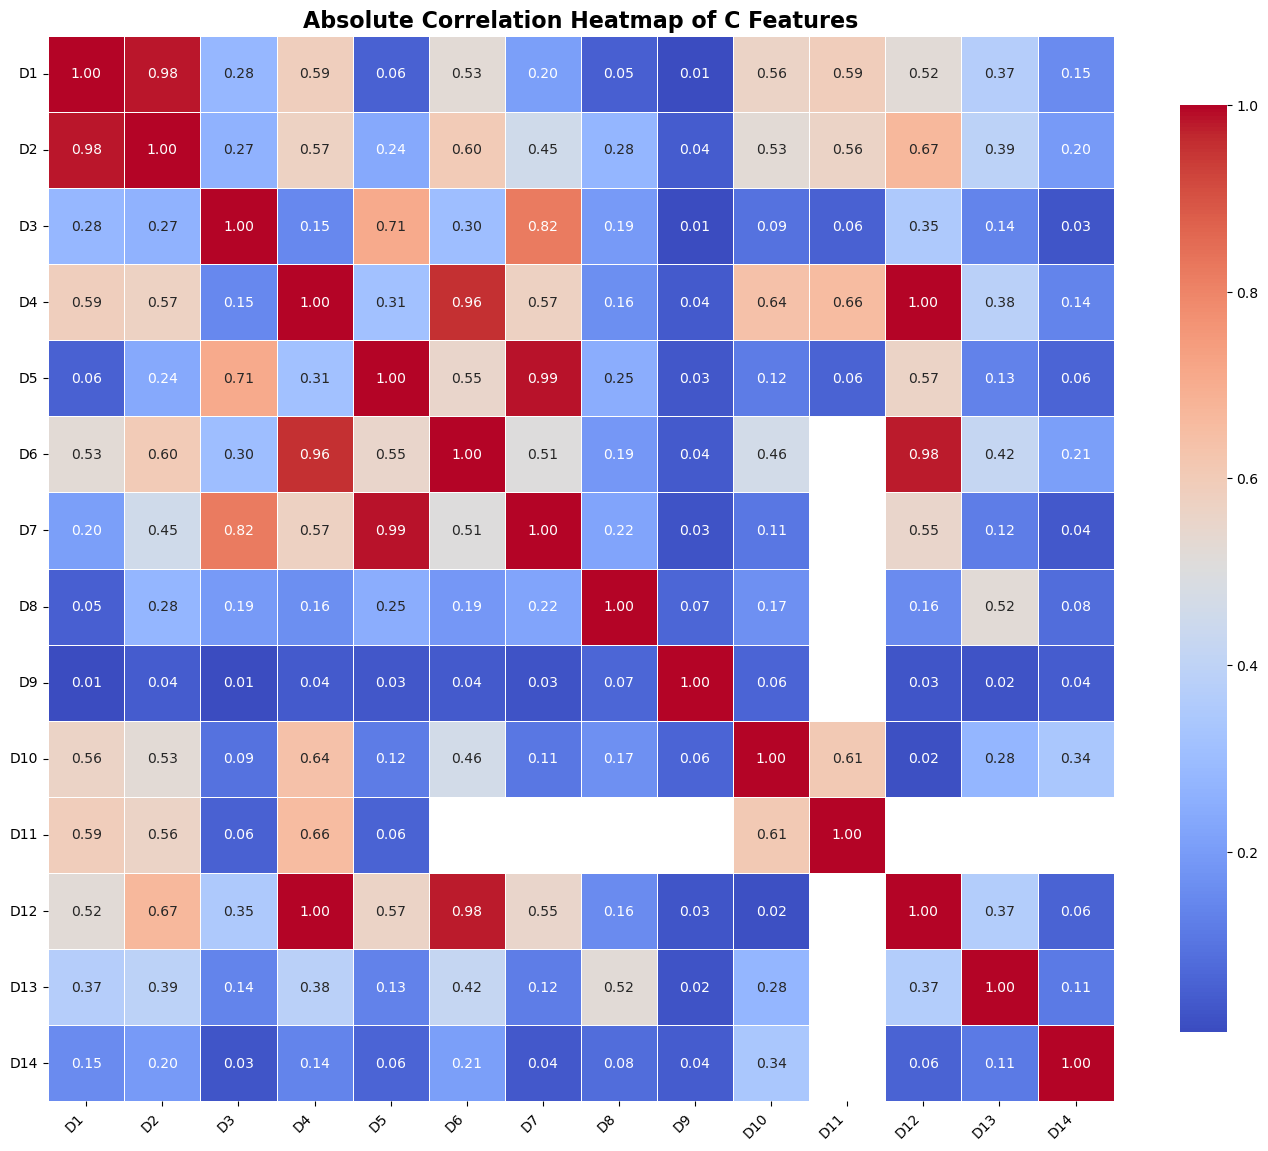

In [686]:
# Compute absolute correlation matrix
corr_matrix = D_features_train_df.corr().abs()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)
plt.title("Absolute Correlation Heatmap of C Features", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [687]:
upper = corr_matrix .where(np.triu(np.ones(corr_matrix .shape), k = 1).astype(bool))

In [688]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [689]:
to_drop

['D2', 'D6', 'D7', 'D12']

In [690]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

C features

In [691]:
C_features_train_df = train_df[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]

In [692]:
cor = C_features_train_df.corr()
cor

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.995089,-0.003467,0.967801,0.165856,0.982238,0.926259,0.967747,0.175994,0.958203,0.996515,0.927940,0.774605,0.951762
C2,0.995089,1.000000,-0.003339,0.972134,0.126536,0.974845,0.938868,0.975864,0.133561,0.970625,0.993898,0.940259,0.751224,0.936150
C3,-0.003467,-0.003339,1.000000,-0.001721,-0.008101,-0.004711,-0.001730,-0.001203,-0.010074,-0.001494,-0.003584,-0.001764,-0.007748,-0.005091
C4,0.967801,0.972134,-0.001721,1.000000,-0.012843,0.962322,0.895092,0.959995,-0.015970,0.952466,0.974548,0.894619,0.644556,0.907679
C5,0.165856,0.126536,-0.008101,-0.012843,1.000000,0.232401,-0.009971,-0.011654,0.925784,-0.011846,0.168856,-0.009876,0.717502,0.378941
C6,0.982238,0.974845,-0.004711,0.962322,0.232401,1.000000,0.858585,0.921974,0.250686,0.914443,0.991105,0.858184,0.808531,0.984201
C7,0.926259,0.938868,-0.001730,0.895092,-0.009971,0.858585,1.000000,0.982983,-0.012399,0.985062,0.915210,0.999489,0.632400,0.794705
C8,0.967747,0.975864,-0.001203,0.959995,-0.011654,0.921974,0.982983,1.000000,-0.014493,0.996970,0.962723,0.983027,0.653251,0.860250
C9,0.175994,0.133561,-0.010074,-0.015970,0.925784,0.250686,-0.012399,-0.014493,1.000000,-0.014731,0.182440,-0.012213,0.704049,0.397387
C10,0.958203,0.970625,-0.001494,0.952466,-0.011846,0.914443,0.985062,0.996970,-0.014731,1.000000,0.956057,0.983817,0.653947,0.853012


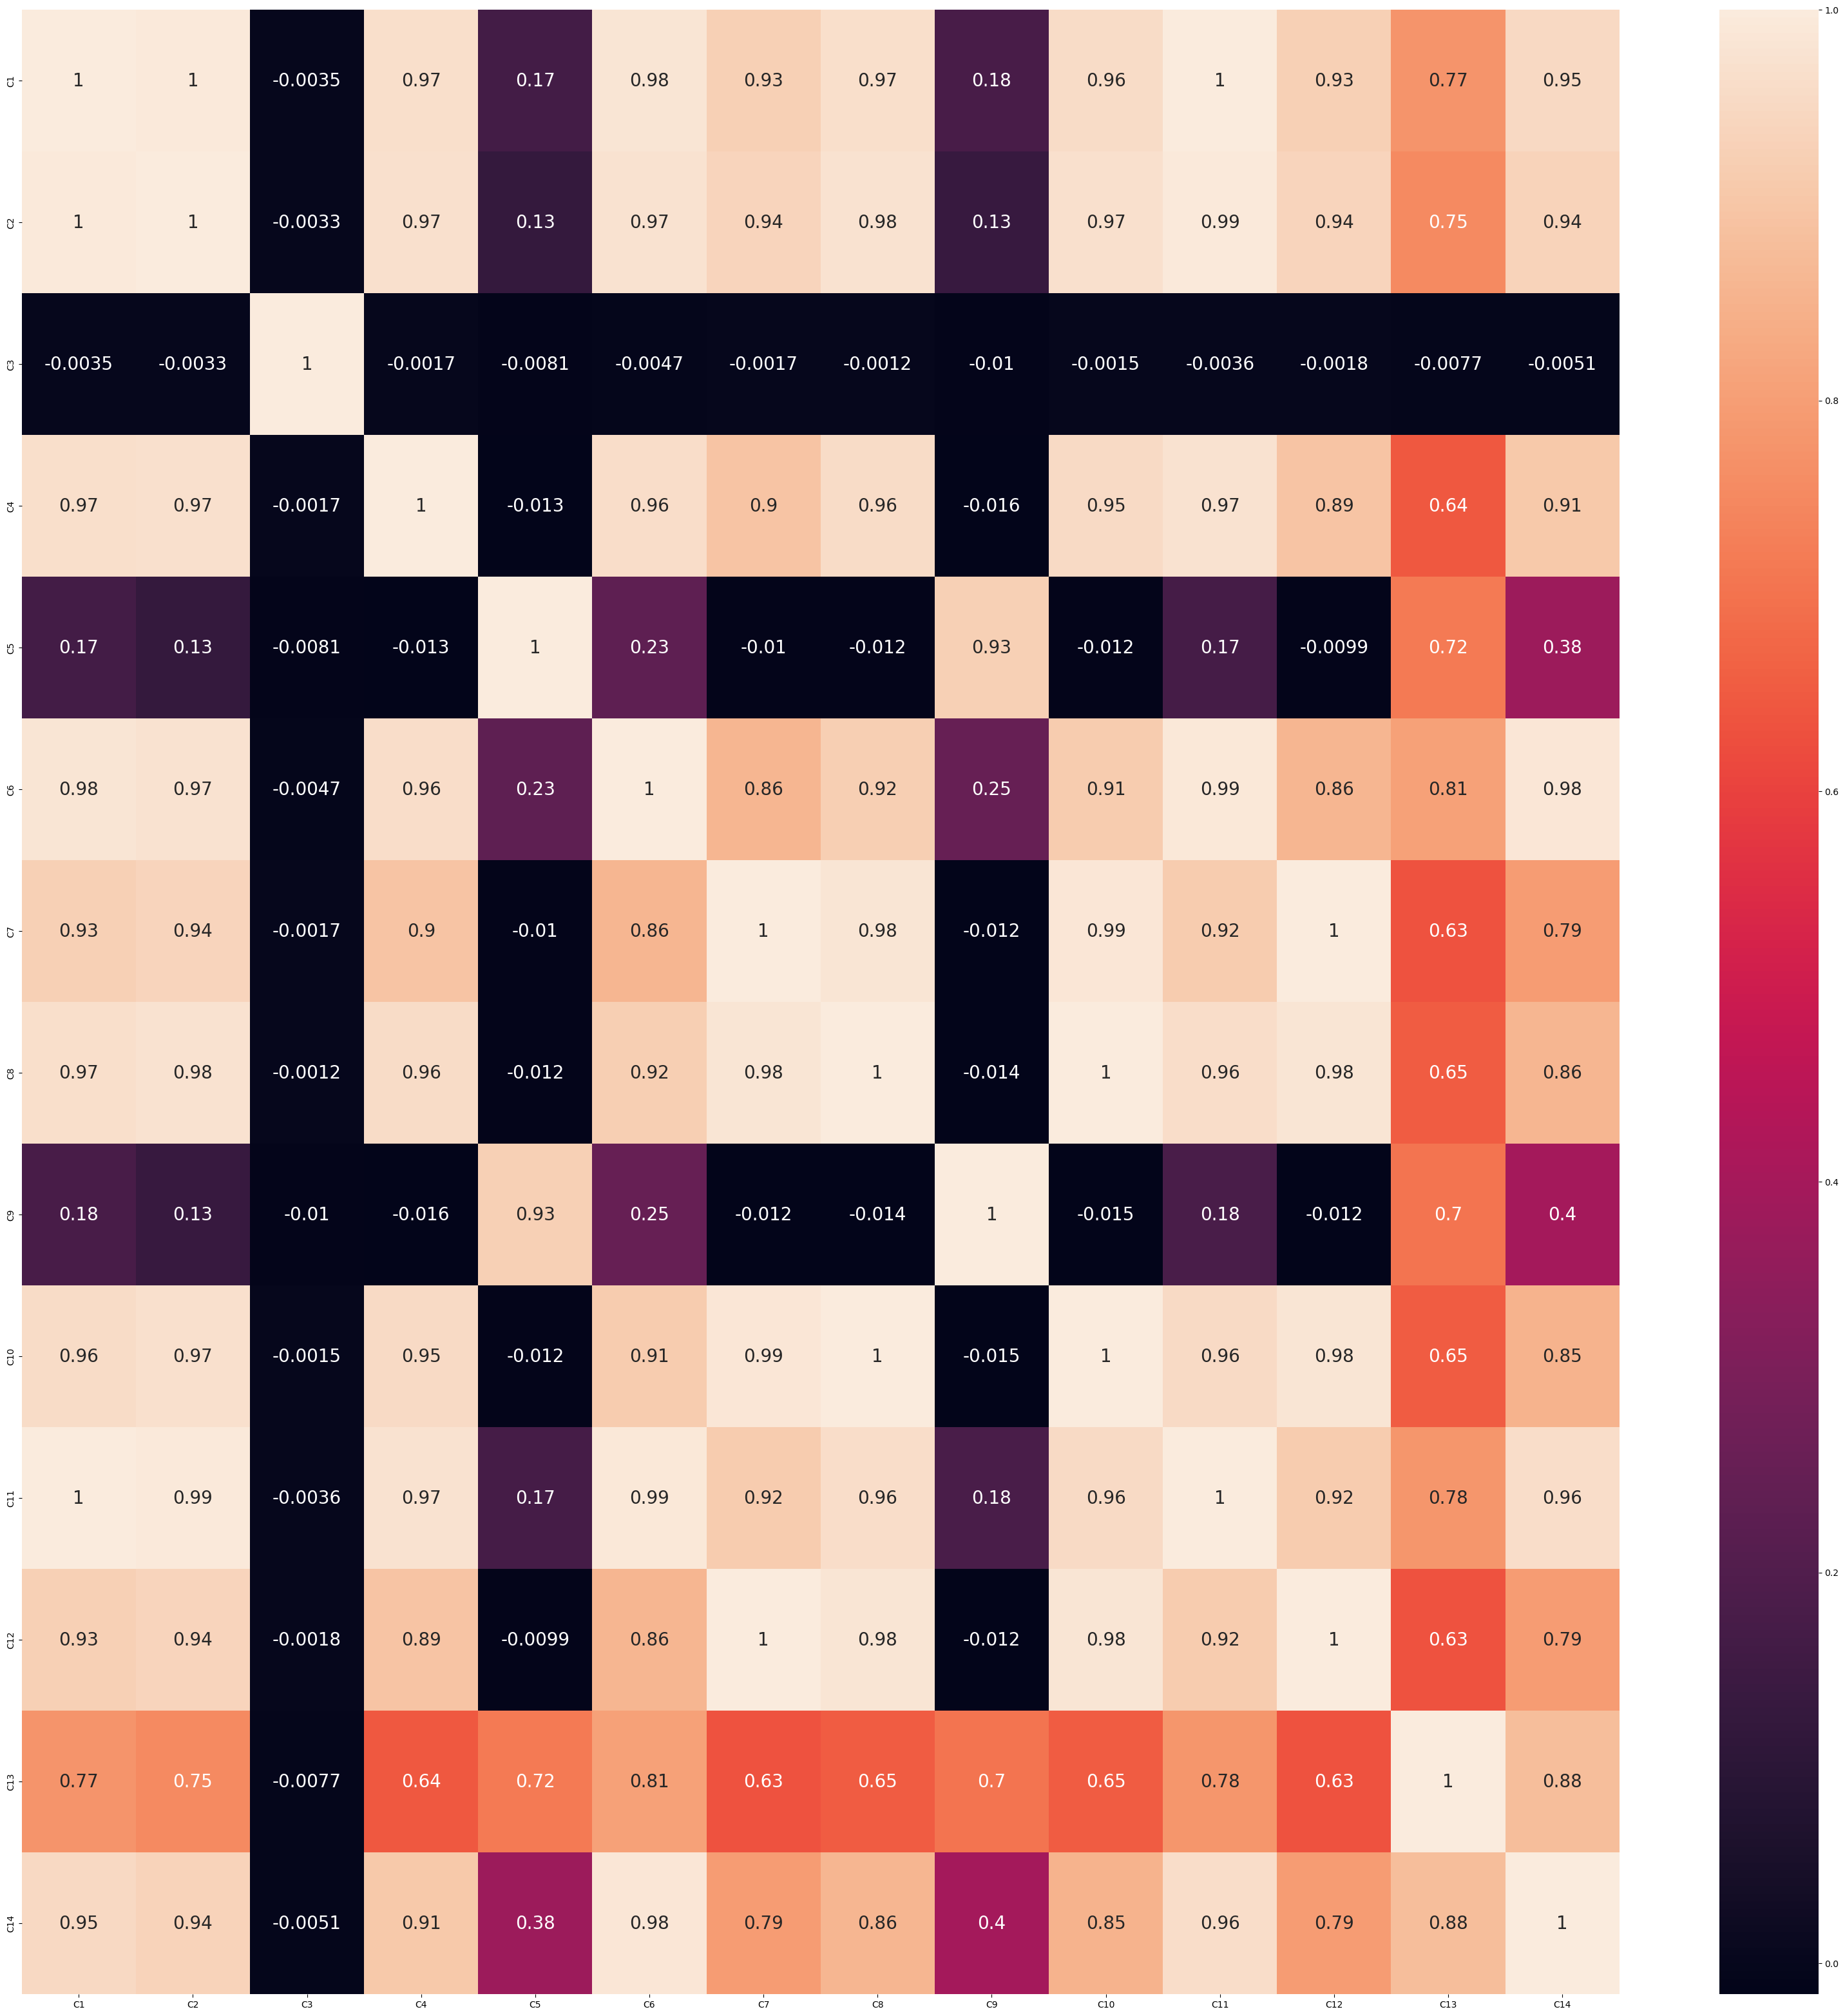

In [693]:
plt.figure(figsize = (40, 40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [694]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1 ).astype(bool))

In [695]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [696]:
to_drop

['C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C12', 'C14']

In [697]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [698]:
del D_features_train_df, C_features_train_df

In [699]:
train_df.columns.to_list()

n_cols = len(train_df.columns.to_list())

print (n_cols)

110


# Removing infinity values

In [700]:
# any infitinte value in dataset
train_df.isin([np.inf, -np.inf]).sum().any()

False

In [701]:
# There are few infinity values
df = train_df.isin([np.inf, -np.inf]).sum()[-2:]
print(df)

DeviceType    0
DeviceInfo    0
dtype: int64


In [702]:
del df

# Data Imputation

In [703]:
# lets convert this inf value to NaN then impute using the mean

train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
test_df.replace([np.inf, -np.inf], np.nan, inplace = True)


In [704]:
# impute numerical value by median for each feature

for i in train_df.columns:
    if train_df[i].dtypes == 'int64' or train_df[i].dtypes == 'int32' or train_df[i].dtypes == 'int16' or train_df[i].dtypes == 'int8' or train_df[i].dtypes == 'float64' or train_df[i].dtypes == 'float32' or train_df[i].dtypes == 'float16' :
        train_df[i].fillna(train_df[i].median(), inplace = True )
        


In [705]:
# imputation of categorical features by mode 

for i in train_df.columns:
    if train_df[i].dtypes == 'object':
        train_df[i].fillna(train_df[i].mode()[0], inplace = True)


In [706]:
# imputation of numerical features with median

for i in test_df.columns:

    if test_df[i].dtypes == 'int64' or test_df[i].dtypes == 'int32' or test_df[i].dtypes == 'int16' or test_df[i].dtypes == 'int8' or test_df[i].dtypes == 'float64' or test_df[i].dtypes == 'float32' or test_df[i].dtypes == 'float16' :
        test_df[i].fillna(test_df[i].median(), inplace = True)
        

In [707]:
# imputation of categorical features by mode

for i in test_df.columns:
    if test_df[i].dtypes == 'object':
        test_df[i].fillna(test_df[i].mode()[0], inplace = True)
        

In [708]:
test_df.isnull().sum().any()

False

In [709]:
# encoding categorical feature before model training using label encoder
from sklearn.preprocessing import LabelEncoder

for i in train_df.columns:
  if train_df[i].dtypes == "object":
    le = LabelEncoder()
    train_df[i] = le.fit_transform(train_df[i].astype(str).values)


In [710]:
#encoding test data using laber encoder

for i in test_df.columns:
  if test_df[i].dtypes == "object":
    le = LabelEncoder()
    test_df[i] = le.fit_transform(test_df[i].astype(str).values)
    

Train Test split

In [711]:
train_df = train_df.sample(frac = .7)

In [712]:
#Train test split

train_data = train_df[:int(train_df.shape[0]*0.80)]
cv_data = train_df[int(train_df.shape[0]*0.80):]

In [713]:
#X-y split

x_train = train_data.drop(['isFraud'], axis = 1)
y_train = train_data['isFraud']
x_cv = cv_data.drop(['isFraud'], axis = 1)
y_cv = cv_data['isFraud']

print(x_train.shape)




(330676, 109)


Feature Scaling

In [714]:
#standardizing the train and cv x for logistic regression model

sc = StandardScaler()
sc_x_train = sc.fit_transform(x_train)
sc_x_cv = sc.transform(x_cv)


# LGBM

In [715]:

parameter_lgbm = {
             'max_depth':[1, 3, 4, 5],
             'learning_rate':[0.001, 0.01, 0.1], 
             'n_estimators': [100, 300, 500, 600, 800, 1100],
             'min_child_samples': sp_randint(100, 400), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1],
             'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 12]
             }


In [716]:

#clf = LGBMClassifier(class_weight='balanced', random_state=42)

# Run randomized search using average_precision (AUPRC)
#rand_clf = RandomizedSearchCV(
   # clf,
   # param_distributions=parameter_lgbm,
   # scoring='average_precision',
   # return_train_score=True,
   # n_iter=50,  # or adjust as needed
   # cv=3,
   # verbose=1,
  #  n_jobs=-1,
   ## random_state=42
#)

# Fit
#rand_clf.fit(x_train, y_train)

# Print results
#print(rand_clf.best_params_)
#print("=" * 60)
#print(rand_clf.best_estimator_)


In [717]:
#training with best parameter
clf_lgbm = LGBMClassifier(class_weight = "balanced", max_depth = 10, min_child_samples = 577, min_child_weight = 14.0, n_estimators = 3900, reg_alpha = 7, reg_lambda = 0, subsample = 0.5489, learning_rate = 0.1)
clf_lgbm.fit(x_train, y_train)


[LightGBM] [Info] Number of positive: 11559, number of negative: 319117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12226
[LightGBM] [Info] Number of data points in the train set: 330676, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(class_weight='balanced', max_depth=10, min_child_samples=577,
               min_child_weight=14.0, n_estimators=3900, reg_alpha=7,
               reg_lambda=0, subsample=0.5489)

In [718]:
y_trainpred = clf_lgbm.predict(x_train)
pred_prob_train = clf_lgbm.predict_proba(x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

Train AUC = 0.9998801897181678


In [719]:
from sklearn.model_selection import StratifiedKFold

X = train_df.drop(columns='isFraud')  
y = train_df['isFraud']              

# Initialize stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Example: Loop over the 5 folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print(f"Fold {fold}:")
    print(f" - Train samples: {X_train.shape[0]}")
    print(f" - Validation samples: {X_val.shape[0]}")
    print("=" * 40)
    


    
    clf_lgbm = LGBMClassifier(class_weight = "balanced", max_depth = 10, min_child_samples = 577, min_child_weight = 14.0, n_estimators = 3900, reg_alpha = 7, reg_lambda = 0, subsample = 0.5489, learning_rate = 0.1)
    clf_lgbm.fit(X_train, y_train)


    y_cvpred     = clf_lgbm.predict(X_val)
    pred_prob_cv = clf_lgbm.predict_proba(X_val)

    # AUC
    print("CV ROC AUC  =", roc_auc_score(y_val, pred_prob_cv[:, 1]))

     # AUPRC score
    auprc = average_precision_score(y_val, pred_prob_cv[:, 1])
    print("CV AUPRC    =", auprc)


Fold 1:
 - Train samples: 330676
 - Validation samples: 82670
[LightGBM] [Info] Number of positive: 11488, number of negative: 319188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12246
[LightGBM] [Info] Number of data points in the train set: 330676, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li